Малахов Александр 
Курсовая работа 8 вариант от Иванова И. Э.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

Зададим все константы согласно выданным значениям и в случае необходимости перейдем к системе СИ

$T_{1}$ = 20 C

$T_{2}$ = 800 C

$α_{1}$ = 25.0 $\frac{вт}{м^2 град}$

$α_{2}$ = 46.5 $\frac{вт}{м^2 град}$

    
h= 50 мм = 0.05 м

A= 55 $\frac{вт}{м град}$

B= -150 $\frac{вт}{м^2 град}$

C= +10 $\frac{вт}{м^3}$

D= 100 $\frac{1}{м^2}$

E= 2

In [2]:
T1 = 20
T2 = 800
ALFA1 = 25.0
ALFA2 = 46.5

h = 0.05
A = 55
B = -150
C = 1000
D = 1000
E = 2

n = 5000

dx = h / n
fx = []
kx = []


def f(x):
    return C * math.exp((-1) * D * (x * dx - h / E) ** 2)


def k(x):
    return A + B * x * dx

Реализуем метод прогонки.

Данный метод должен принимать матрицу, правую часть и число уравнений

Метод стоит применять для решения СЛАУ, которые можно представить в виде трехдиагональнйо матрицы

$$a_{i}x_{i-1} + b_{i}x_{i}+c_{i}x_{i+1}=f_{i}$$

b - диагональ, лежащая над главной (нумеруется: [0;n-2])

c - главная диагональ матрицы A (нумеруется: [0;n-1])

a - диагональ, лежащая под главной (нумеруется: [1;n-1])

Данный метод находит решение СЛАУ за 2 подхода.

В 1 находит коэффициенты $$P_{i}\:и\:Q_{i}$$

Во 2 расчитываются значения неизвестных 

$$T(x_{n})=Q_{n}$$

$$T(x_{i})=P_{i}*T(x_{i+1})+Q_{i}, \:где \:i = \overline{1,n-1}$$

In [3]:
def sufficiency_check(matrix, n):
    if(abs(matrix[0][1]) > 1) or (abs(matrix[n-1][n-1]) > 1) or (abs(matrix[0][1]) + abs(matrix[n-1][n-1]) >= 2):
        raise Exception("Данная матрица не удовлетворяет достаточному условию метода прогонки")

    for i in range(1, n-1):
        if round(abs(matrix[i][i-1]) + abs(matrix[i][i+1]) - abs(matrix[i][i])) > 0:
            raise Exception("Данная матрица не удовлетворяет достаточному условию метода прогонки")

def TDMA(matrix, f, n):
    sufficiency_check(matrix, n)
    P = [0] * (n)
    Q = [0] * (n)
    

    P[0] = (-1) * matrix[0][1]/matrix[0][0]
    Q[0] = f[0] / matrix[0][0]

    for i in range(1,n-1):
        tmp = matrix[i][i] + matrix[i][i-1] * P[i-1]
        P[i] = (-1) * matrix[i][i+1]/tmp
        Q[i] = (f[i] - matrix[i][i-1] * Q[i-1]) / tmp

    Q[n-1] = (f[n-1] - matrix[n-1][n-2] * Q[n-2]) / (matrix[n-1][n-1] + matrix[n-1][n-2] * P[n-2])
    
    result = [0] * (n)
    for i in reversed(range(n)):
        if(i == n-1):
            result[i] = Q[i]
        else:
            result[i] = P[i]* result[i+1] + Q[i]
    return result

Заполняем матрицу и правую часть

In [4]:
for i in range(n):
    kx.append(k(i))
    fx.append(f(i))

matrix = [0] * (n)


matrix[0] = [0] * (n)
matrix[0][0] = 1
matrix[0][1] = (-1) * kx[0] / (kx[0] + dx * ALFA1)


for i in range(1, n - 1):
    matrix[i] = [0] * (n)
    matrix[i][i - 1] = (kx[i - 1] + 4 * kx[i] - kx[i + 1]) / (4 * (dx ** 2))
    matrix[i][i] = (-2) * kx[i] / (dx ** 2)
    matrix[i][i + 1] = ((-1) * kx[i - 1] + 4 * kx[i] + kx[i + 1]) / (4 * (dx ** 2))


matrix[n - 1] = [0] * (n)
matrix[n - 1][n - 1] = 1
matrix[n - 1][n - 2] = (-1) * kx[n - 1] / (kx[n - 1] + dx * ALFA2)

f = [0] * (n)
f[0] = ALFA1 * T1 / (kx[0] / dx + ALFA1)
f[n - 1] = ALFA2 * T2 / (kx[n - 1] / dx + ALFA2)
for i in range(1, n - 1):
    f[i] = fx[i]

Вычисляем распределение температуры двумя способами

In [5]:
temp_numpy = np.linalg.solve(matrix, f)
temp_tdma = TDMA(matrix, f, n)

Вычисляем распределенние теплового потока через стенку

In [6]:
heat_flow = [0] * (n)

heat_flow[0] = (-1) * kx[0] * (temp_tdma[1] - temp_tdma[0]) / dx

for i in range(1, n-1):
    heat_flow[i] = (-1) * kx[i] * (temp_tdma[i + 1] - temp_tdma[i - 1]) / (2 * dx)

heat_flow[n - 1] = (-1) * kx[n - 1] * (temp_tdma[n - 1] - temp_tdma[n - 2]) / dx

Преобразуем x к нужному диапозону и строим графики

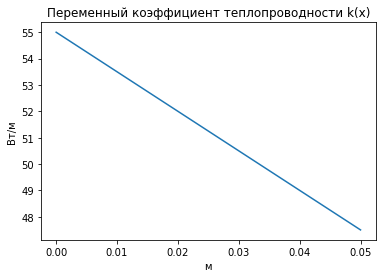

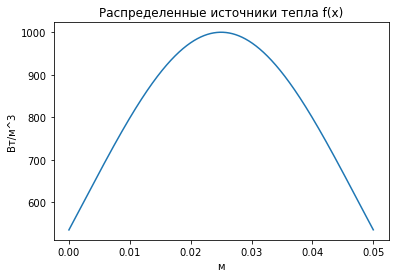

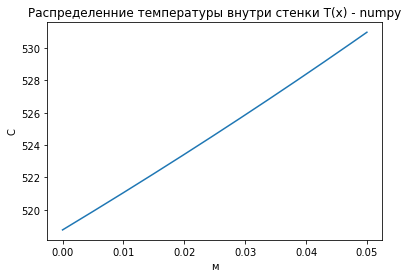

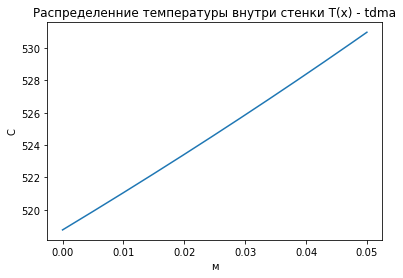

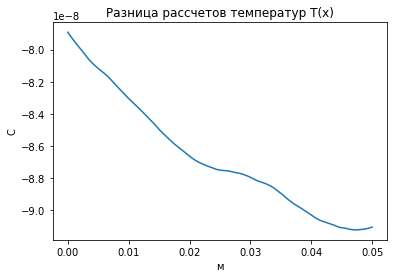

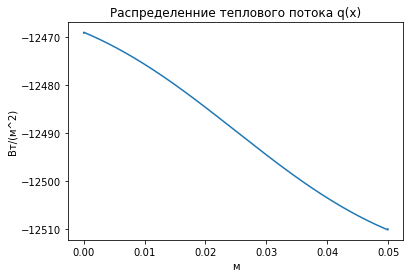

In [7]:
x = []
for i in range(n):
    x.append(i * dx)
plt.plot(x, kx)
plt.title("Переменный коэффициент теплопроводности k(x)")
plt.xlabel("м")
plt.ylabel("Вт/м")
plt.show()

plt.plot(x, fx)
plt.title("Распределенные источники тепла f(x)")
plt.xlabel("м")
plt.ylabel("Вт/м^3")
plt.show()

plt.plot(x, temp_numpy)
plt.title("Распределенние температуры внутри стенки T(x) - numpy")
plt.xlabel("м")
plt.ylabel("C")
plt.show()

plt.plot(x, temp_tdma)
plt.title("Распределенние температуры внутри стенки T(x) - tdma")
plt.xlabel("м")
plt.ylabel("C")
plt.show()

plt.plot(x, list(map(lambda x, y: x - y, temp_numpy, temp_tdma)))
plt.title("Разница рассчетов температур T(x)")
plt.xlabel("м")
plt.ylabel("C")
plt.show()

plt.plot(x, heat_flow)
plt.title("Распределенние теплового потока q(x)")
plt.xlabel("м")
plt.ylabel("Вт/(м^2)")
plt.show()